In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import display
import IPython
import math

For this assignment, I used a dataset from UCI, the CMU faces dataset:
https://archive.ics.uci.edu/ml/datasets/CMU+Face+Images
I chose the image classification goal of determining whether or not an individual in the image was wearing sunglasses, as this should be a fairly simple image recognition task, since the sunglasses look very similar and all the photos have similar lighting and positioning.

## Task 1
### Create a convolutional base using a common pattern: a stack of Conv and MaxPooling layers. Add the final dense layer(s). Compile and train the model. Report the final evaluation and describe the metrics.

First, I prepare the data. I use `tf.keras.utils.image_dataset_from_directory` to prepare the train, dev, and test sets. This function expects a specific directory structure. Check out `data/convert.py` to see how I do data preparation and split the data into the three sets. It uses a 80-10-10 split.

If you want to run yourself, download and extract the dataset so the `faces` folder is present in the `./data` directory, then run `convert.py` in that directory.

The dataset comes with scaled images for each sample. I filter out so we only use the highest resolution images, which are 128x120 pixels, in grayscale.

In [4]:
# in form of y-dim, x-dim, because tensorflow appears to use this
img_shape = (120, 128)
def dataset():
    kwargs = {
        'batch_size': None,
        'color_mode': 'grayscale',
        'label_mode': 'binary',
        'shuffle': False,
        'image_size': img_shape
    }
    train = tf.keras.utils.image_dataset_from_directory('data/pngs/train', **kwargs)
    validation = tf.keras.utils.image_dataset_from_directory('data/pngs/validation', **kwargs)
    test = tf.keras.utils.image_dataset_from_directory('data/pngs/test', **kwargs)
    return train, validation, test
train, val, test_set = dataset()

Found 499 files belonging to 2 classes.
Found 62 files belonging to 2 classes.
Found 63 files belonging to 2 classes.


A bit of EDA. Here are some example images.

(120, 128, 1)


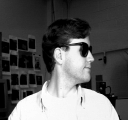

has sunglasses: yes


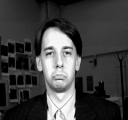

has sunglasses: no


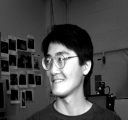

has sunglasses: no


In [5]:
def showimg(img_tensor):
    img = tf.keras.utils.array_to_img(img_tensor)
    display(img)
def get_train_img(n):
    return train.skip(n).take(1).get_single_element()
def _show(n):
    train_img, train_label = get_train_img(n)
    showimg(train_img)
    print (f'has sunglasses: {"yes" if train_label > 0.5 else "no"}')
train_img, train_label = get_train_img(300)
print(train_img.shape)
_show(300)
_show(200)
_show(100)

The input shape needs to go by y-coordinate first, this seems to be how keras expects images to be represented using its `array_to_img` utility. Additionally, it has only 1 channel since it is a grayscale image, so that is why there is a trailing 1.

In [34]:
num_sunglasses = len([a for a in train if a[1] > 0.5])
print (f'number of samples with sunglasses: {num_sunglasses}, total samples: {len(train)}, ratio: {float(num_sunglasses)/len(train)}')

number of samples with sunglasses: 248, total samples: 499, ratio: 0.4969939879759519


Since we have approximately an equal amount of samples in each class, we don't need to perform any sort of weighted sampling method to ensure our classifier isn't biased.

#### Evaluating different models
I started with 3 sets of convolution followed by max pooling layers. My initial thoughts for choosing this were that certain examples we discussed in lecture used 3 layers, and likely identifying sunglasses isn't particularly challenging for an image recognition problem, since its a similarly sized and similarly shaped dark set of pixels in a predictable location in the image. More layers would likely be overfitting / too complex of a model. Additionally, by using 3 pooling layers with decently sized kernels, the final fully connected layer has a limited number of trainable parameters.

In [8]:
def keras_model(kernel_initializer='glorot_uniform', final_pooling_layer=False, n_med_filter=1, final_pooling_layer_size=(3,3)):
    tf.keras.utils.set_random_seed(1)    
    m = tf.keras.Sequential()
    m.add(tf.keras.layers.Input((img_shape[0], img_shape[1], 1)))
    # rescale grayscale 0-256 values to 0-1
    m.add(tf.keras.layers.Rescaling(float(1)/256))
    m.add(tf.keras.layers.Conv2D(filters=1, kernel_size=3))
    m.add(tf.keras.layers.MaxPooling2D((3,3)))
    m.add(tf.keras.layers.Conv2D(filters=n_med_filter, kernel_size=3))
    m.add(tf.keras.layers.MaxPooling2D((3,3)))
    m.add(tf.keras.layers.Conv2D(filters=1, kernel_size=3))
    if final_pooling_layer:
        m.add(tf.keras.layers.MaxPooling2D(final_pooling_layer_size))
    m.add(tf.keras.layers.Flatten())
    m.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
    m.summary()
    # also create duplicate model that we can leave untrained, and compare weights afterward
    model_untrained = tf.keras.models.clone_model(m)
    model_untrained.set_weights(m.get_weights())    
    return m, model_untrained

The following was my initial model. It contains 3 convolutional layers, each with a SINGLE 3x3 filter, and 3x3 max pooling layers after the first two convolutional layers.
I rescale the input by 1/256 so brightness values range from 0 to 1.
The final fully connected layer has a considerable number of trainable parameters, at 111. This is due to taking a 10x11 input from the previous convolutional layer.

In [9]:
def randomize(dataset):
    # len dataset should be # of samples, so we reshuffle order after going through all samples
    # shuffling before batching is important! otherwise end up with batches only containing sunglasses or no sunglasses (learned the hard way)
    return dataset.cache().shuffle(len(dataset), seed=1, reshuffle_each_iteration=True).batch(32)

In [10]:
m1, mu1 = keras_model()

hist1 = m1.fit(x=randomize(train), validation_data=randomize(val), epochs=35, verbose=0)
print ('done')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 118, 126, 1)       10        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 42, 1)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 40, 1)         10        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 13, 1)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 11, 1)         1

In [11]:
def graphs(history):
    ''' render training stats '''
    num_epochs = len(history.history['val_loss'])
    xs = list(range(num_epochs))
    fig, ax = plt.subplots(2, 1)
    def scatter(i, label):
        ax[i].scatter(x=xs, y=history.history[label], label=label)
    for label, plot in [('loss', 1), ('val_loss', 1), ('val_binary_accuracy', 0)]:
        scatter(plot, label)
    ax[0].set_xlabel('epochs')
    ax[1].set_xlabel('epochs')
    ax[0].legend()
    ax[1].legend()
    plt.show()

62/62 [==============================] - 1s 6ms/step - loss: 0.3349 - binary_accuracy: 0.8548


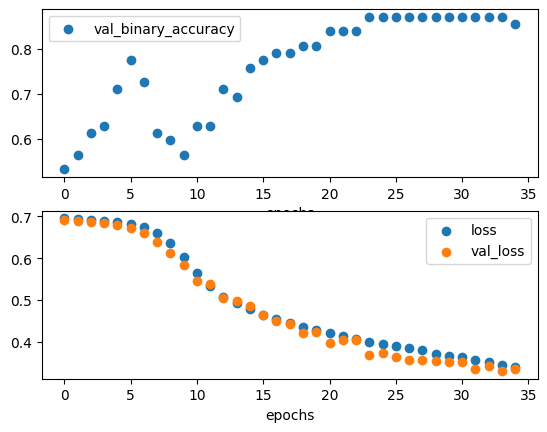

In [15]:
m1.evaluate(val.batch(1))
graphs(hist1)

As we can see, this simple model, with only 1 filter at each of the 3 convolutional layers, performs very well, with >80% accuracy! As we begin too see, its performance peaks past ~30 epochs on the validation binary accuracy.

However, I was particularly concerned about the large (well, for this problem) number of trainable parameters on the final fully connected layer.
The reason why I didn't want many trainable parameters on the final dense layer, is because I suspected that it would be more expensive to train, with not much benefit, and result in a poor bias variance tradeoff. I suspected it would result in low bias and high variance because the final dense layer would be weighting many different features from the feature map, with each output of the feature map corresponding with a feature at a certain position in the image. However, because the presence or absence of sunglasses or absence of them is a property of the "entire image", and it appears at a similar, central location in each sample, it doesn't make a ton of sense to have seperate weights for having the "sunglasses feature" appear in different locations of the feature map. So, ultimately, the final dense layer would likely have similar weights for all of the inputs. However, to train those weights appropriately, we would need a much larger number of samples.

I visualize these weights below for the initial model, both untrained and trained. Note, I used the default random initialization for the dense layer weights.

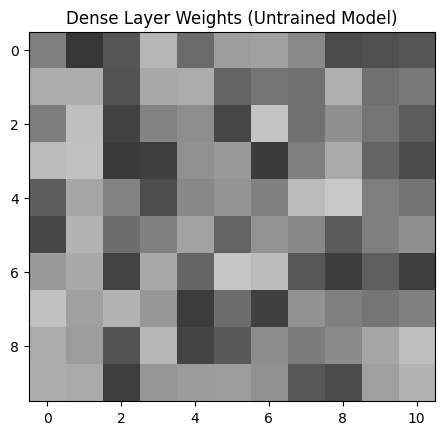

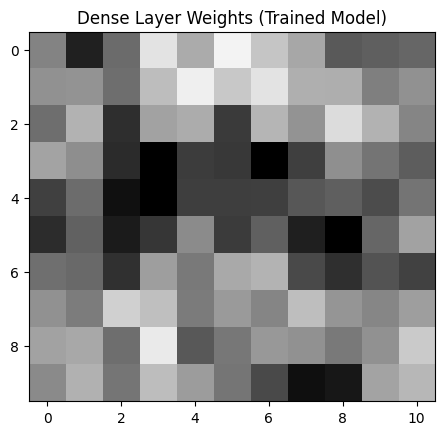

In [16]:
def show_layer_weights(layer, x, y, title=None):
    _w = layer.weights[0]
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.imshow(tf.reshape(_w, (x, y, 1)), cmap='gray', vmin=-0.4, vmax=0.4)
    plt.show()
def show_dense_layer_weights(m, **kwargs):
    prev_nonflat = m.layers[-3].output_shape
    show_layer_weights(m.layers[-1], prev_nonflat[1],  prev_nonflat[2], **kwargs)

show_dense_layer_weights(mu1, title='Dense Layer Weights (Untrained Model)')
show_dense_layer_weights(m1, title='Dense Layer Weights (Trained Model)')

The weights near the center start to take on slightly more extreme values (more negative). I suspect this is due to sunglasses appearing near the center of the image.
One hyperparameter I adjusted was the weight initialization of this model to all-zero weights for the final fully-connected layer. I was curious to see if the final dense layer would start favoring features towards the "center" of the incoming convolutional feature map, since sunglasses are near the center.

In [14]:
m2, mu2 = keras_model(kernel_initializer='zeros')
hist2 = m2.fit(x=randomize(train), validation_data=randomize(val), epochs=35, verbose=0)
print ('done')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 120, 128, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 118, 126, 1)       10        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 39, 42, 1)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 40, 1)         10        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 13, 1)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 11, 1)        

62/62 [==============================] - 0s 5ms/step - loss: 0.9262 - binary_accuracy: 0.6290


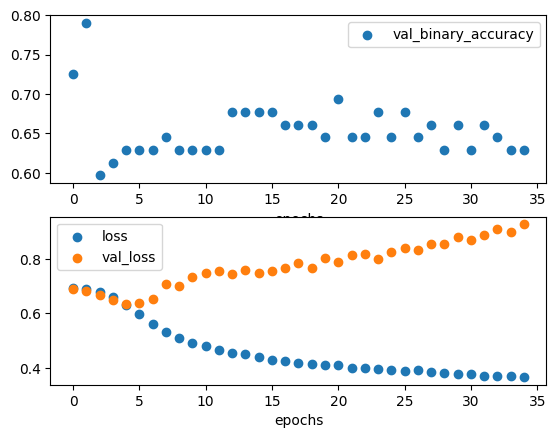

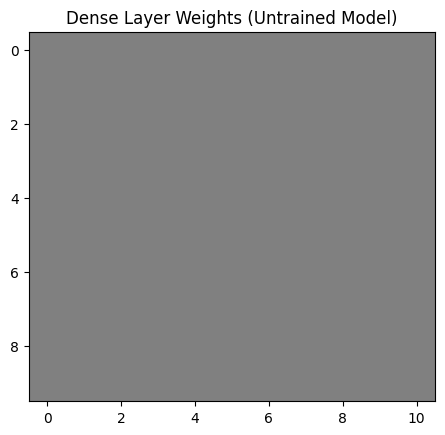

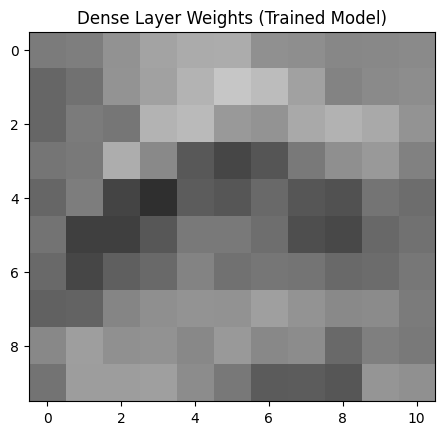

In [17]:
m2.evaluate(val.batch(1))
graphs(hist2)
show_dense_layer_weights(mu2, title='Dense Layer Weights (Untrained Model)')
show_dense_layer_weights(m2, title='Dense Layer Weights (Trained Model)')

Similarly, the dense layer weights now show a considerable distinction between some weight values spatially located in the center, however, validation loss deviated from training loss very early on. I suspect this is due to the symmetry problem with neural network weights, however I was surprised it was this considerable, since this contradicted my hypothesis that the final dense layer weights didn't capture much information.

A different method to reduce the number of parameters in the final layer is to reduce the size of the input to the dense layer. I suspected this might perform better as we wouldn't have the symmetry problem. I added a final pooling layer after the 3rd convolutional layer to reduce the size of the final dense layer to only a 9-output feature map.

In [18]:
m3, mu3 = keras_model(final_pooling_layer=True)
hist3 = m3.fit(x=randomize(train), validation_data=randomize(val), epochs=50, verbose=0)
print ('done')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 120, 128, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 118, 126, 1)       10        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 39, 42, 1)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 40, 1)         10        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 13, 1)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 11, 1)        

62/62 [==============================] - 0s 7ms/step - loss: 0.6592 - binary_accuracy: 0.6290


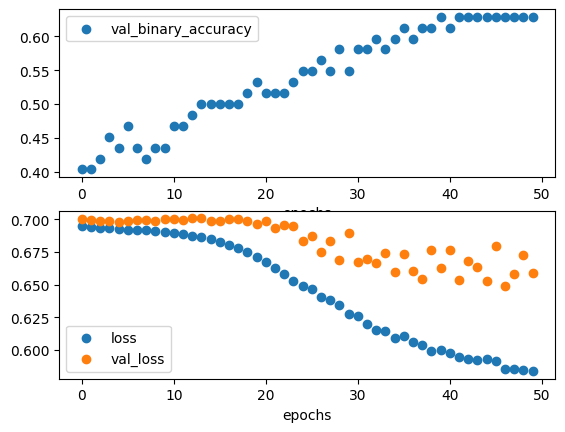

In [19]:
m3.evaluate(val.batch(1))
graphs(hist3)

With this model, we required significantly more iterations to train (we still haven't converged yet with the above number of epochs), and accuracy is still low. This is still suboptimal. I also tried with the final pooling layer, but instead using more filters in the 2nd convolutional layer, to try and extract more "intermediate" features.

In [20]:
m4, mu4 = keras_model(final_pooling_layer=True, n_med_filter=2)
hist4 = m4.fit(x=randomize(train), validation_data=randomize(val), epochs=80, verbose=0)
print ('done')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 120, 128, 1)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 118, 126, 1)       10        
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 39, 42, 1)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 40, 2)         20        
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 13, 2)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 11, 1)        

62/62 [==============================] - 0s 4ms/step - loss: 0.4423 - binary_accuracy: 0.7258


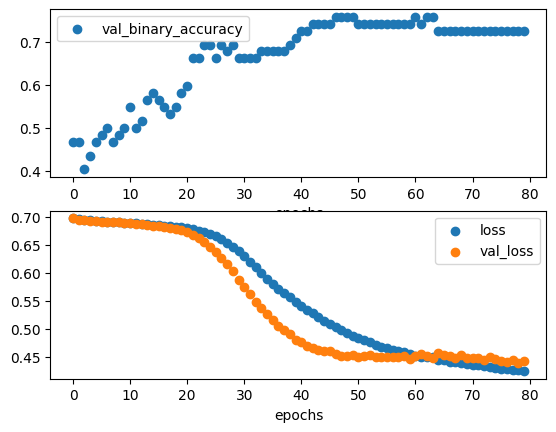

In [21]:
m4.evaluate(val.batch(1))
graphs(hist4)

With a second filter in the second layer, better performance could be reached, but still not as much as with the larger dense layer. I reverted my decision to keep the max pooling layer, but also decided to increase the number of intermediate filters, since this yielded an increase in performance while other hyperparameters remained the same.

In [22]:
m5, mu5 = keras_model(final_pooling_layer=False, n_med_filter=3)
hist5 = m5.fit(x=randomize(train), validation_data=randomize(val), epochs=160, verbose=0)
print ('done')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 120, 128, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 118, 126, 1)       10        
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 39, 42, 1)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 37, 40, 3)         30        
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 12, 13, 3)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 11, 1)        

62/62 [==============================] - 0s 4ms/step - loss: 0.0546 - binary_accuracy: 0.9839


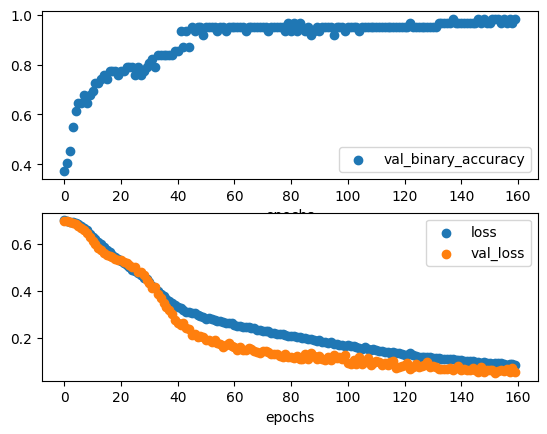

In [23]:
m5.evaluate(val.batch(1))
graphs(hist5)

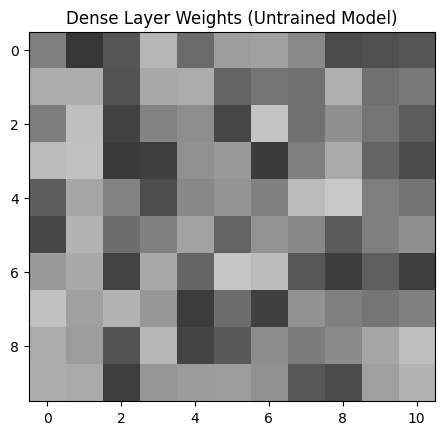

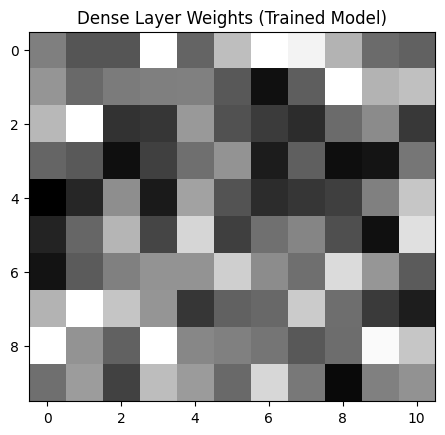

In [24]:
show_dense_layer_weights(mu5, title='Dense Layer Weights (Untrained Model)')
show_dense_layer_weights(m5, title='Dense Layer Weights (Trained Model)')

This model required significantly more time to train, but the results were great, achieving 95%+ accuracy on both the training and validation sets! The additional filters in the intermediate convolutional layer made all the difference.

Additionally, we can visualize the output of some of the convolutional layers to gain insight into their function.
Here is a visualization of the final convolutional layer, right before the dense layer, on a few different inputs.

(1, 10, 11, 1)


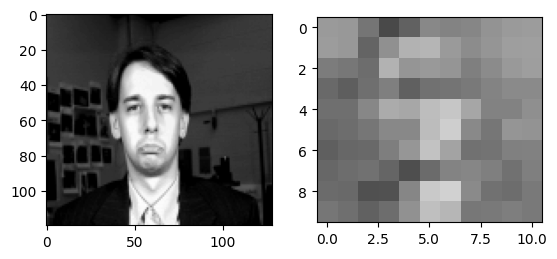

(1, 10, 11, 1)


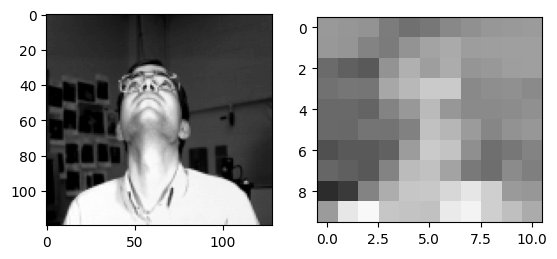

(1, 10, 11, 1)


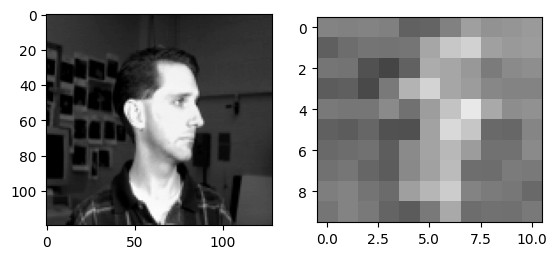

(1, 10, 11, 1)


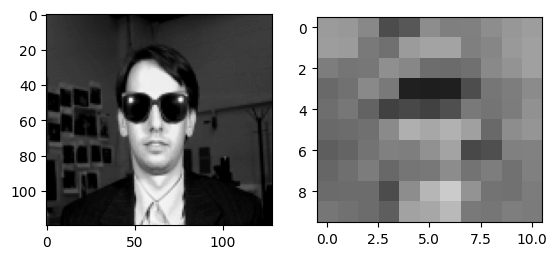

(1, 10, 11, 1)


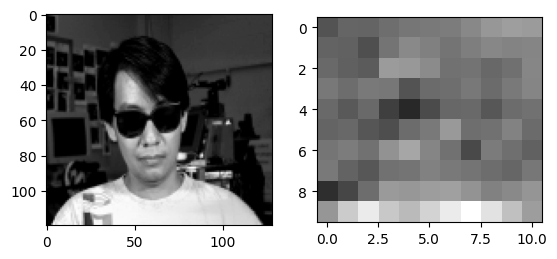

(1, 10, 11, 1)


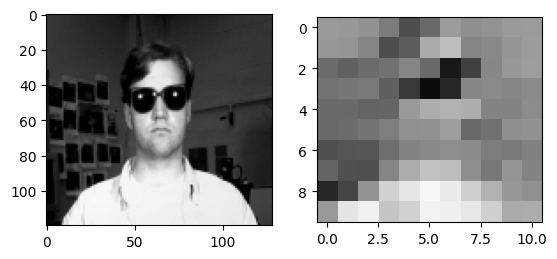

In [25]:
def test_layer(m, n):
    train_img, train_label = get_train_img(n)
    x = tf.reshape(train_img, (1, img_shape[0], img_shape[1], 1))
    y = tf.keras.backend.function([m.layers[0].input], [m.layers[5].output])([[x]])[0]
    print (y.shape)
    z = tf.reshape(y, (y.shape[1], y.shape[2]))
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(tf.reshape(train_img, (img_shape[0], img_shape[1])), cmap='gray')
    _min = -20
    _max = 20
    axes[1].imshow(z, vmin=_min, vmax=_max, cmap='gray')
    plt.show()
test_layer(m5, 200)
test_layer(m5, 30)
test_layer(m5, 35)
test_layer(m5, 450)
test_layer(m5, 400)
test_layer(m5, 310)

Note that each of the above convolution images renders pixels on a scale from -20 to 20. Output values from the convolution layer above or below that threshold appear as the same black or white color. 20 appeared to be large enough to capture the range of values appropriately.

I speculate that the darker (lower activation) areas correspond with what is perceived as sunglasses. The final convolution layer gives a really low output value spatially where sunglasses tend to be. Spatially in the center of the convolution output, where peoples faces are, we see lighter values when there are no sunglasses. The neutral activation / almost 0 / medium-greyish pixels represent activations that have little effect on the final output logit value, which most of the edge pixels are, since sunglasses tend not to be there!

This also justifies our choice of not padding the data, since pixels near the edge of the image aren't very important.

As our final model, we can test on the test set to evaluate its performance:

In [26]:
m5.evaluate(test_set.cache().batch(1))

63/63 [==============================] - 0s 5ms/step - loss: 0.4719 - binary_accuracy: 0.8571


[0.47192394733428955, 0.8571428656578064]

85% accuracy is very respectable! Again, accuracy is a good metric here, because our classes are balanced (similar number of sunglasses and non-sunglasses images)

### Part 2. Choose any one of the above models to perform the classification task you did in Part 1. Evaluate the results using the same metrics as in Part 1.
I will try and use VGG16. It comes with >100mil parameters by default, which is many orders of magnitude larger than the model I used. I suspect this will be quite unweildy to train.

In [30]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
# change shape to shape of our image, unfortunately we still have to use 3 channels, so we have to modify our data from grayscale to rgb
# include_top=False gets rid of the final classification layer, instead I will put my own binary classification layer
vgg16_pretrained = VGG16(include_top=False, input_shape=(img_shape[0], img_shape[1], 3))
vgg16_pretrained.summary()
vgg16_pretrained.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 120, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 32, 128)       0     

In [31]:
# training based on https://keras.io/guides/transfer_learning/
# adjust input shape to appropriate image size, however, 3 channels are still necessary, so we will have to adjust our data
inputs = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], 3))
x = vgg16_pretrained(inputs)
# flatten final layer so that we can have one fully connected layer afterwards
x = tf.keras.layers.Flatten()(x)
# use a single output fully connected node, with sigmoid activation, for binary classification
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
mvgg = tf.keras.models.Model(inputs=inputs, outputs=output)
def randomize2(dataset):
    return dataset.shuffle(len(dataset), seed=1, reshuffle_each_iteration=True).batch(32)
# apply image preprocessing to the data, converting it to rgb
def preprocess_dataset(ds):
    return ds.map(lambda x, y: (preprocess_input(tf.image.grayscale_to_rgb(x)), y))
train_vgg, val_vgg, test_set_vgg = [preprocess_dataset(a) for a in [train, val, test_set]]

mvgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
histvgg = mvgg.fit(randomize2(train_vgg), validation_data=randomize2(val_vgg), epochs=10)

Epoch 1/10
16/16 [==============================] - 13s 711ms/step - loss: 3.9629 - binary_accuracy: 0.5932 - val_loss: 0.3056 - val_binary_accuracy: 0.9194
Epoch 2/10
16/16 [==============================] - 11s 674ms/step - loss: 0.3473 - binary_accuracy: 0.9058 - val_loss: 0.1092 - val_binary_accuracy: 0.9677
Epoch 3/10
16/16 [==============================] - 11s 701ms/step - loss: 0.0650 - binary_accuracy: 0.9840 - val_loss: 0.1257 - val_binary_accuracy: 0.9355
Epoch 4/10
16/16 [==============================] - 11s 655ms/step - loss: 0.0308 - binary_accuracy: 0.9860 - val_loss: 0.1134 - val_binary_accuracy: 0.9355
Epoch 5/10
16/16 [==============================] - 11s 656ms/step - loss: 0.0082 - binary_accuracy: 1.0000 - val_loss: 0.0939 - val_binary_accuracy: 0.9677
Epoch 6/10
16/16 [==============================] - 10s 652ms/step - loss: 0.0071 - binary_accuracy: 1.0000 - val_loss: 0.0963 - val_binary_accuracy: 0.9677
Epoch 7/10
16/16 [==============================] - 10s 64

62/62 [==============================] - 3s 42ms/step - loss: 0.0914 - binary_accuracy: 0.9839


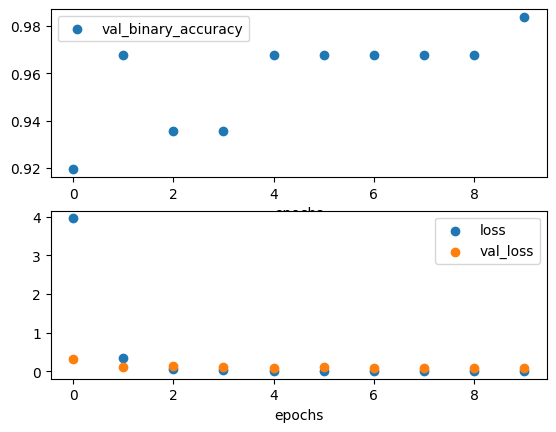

In [32]:
mvgg.evaluate(val_vgg.batch(1))
graphs(histvgg)

It looks like VGG performs even better than our model, at >90% accuracy, and stops improving binary accuracy after about 10 epochs.
I'll evaluate it on the test set (I'm treating this as a different problem than part 1, so its ok to evaluate on test set).

In [35]:
mvgg.evaluate(test_set_vgg.batch(1))

63/63 [==============================] - 3s 42ms/step - loss: 0.1658 - binary_accuracy: 0.9524


[0.1658197045326233, 0.9523809552192688]

Nice! This is a significant improvement over our from-scratch model.
We achieved about a 10% increase in accuracy over the from-sctach model on the test set.
We can assume that VGG16 does a better job modelling the latent features of the image, and so it can discern sunglasses better. This doesn't surprise me, as my from scratch model (model 5) uses only 179 parameters, compared to vgg16 which uses practically 10^6 times as many parameters! However, for only a 10% improvement, there may be circumstances in which the from-scratch model with 179 parameters is preferable, due to computational efficiency.

### Part 3: Use data augmentation to increase the diversity of your dataset by applying random transformations such as image rotation (you can use any other technique as well). Repeat the process from part 1 with this augmented data. Did you observe any difference in results?
I'll use the model we ended up choosing in part 1, but fit with different augmented data.

Because all of the pictures are taken head-on, with no rotation, I suspect many image augmentation techniques like rotation, translation, and zooming aren't useful, as the algorithm can rely on position of the sunglasses to be consistent in the image.

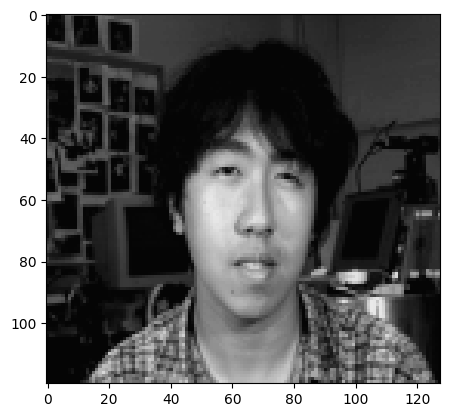

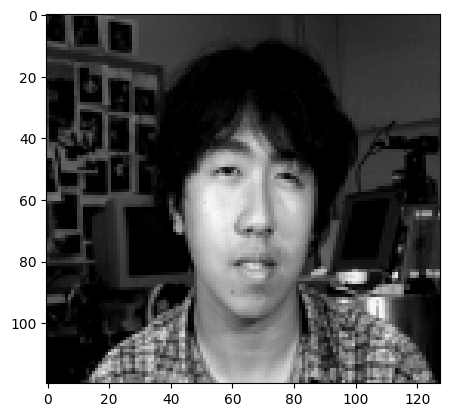

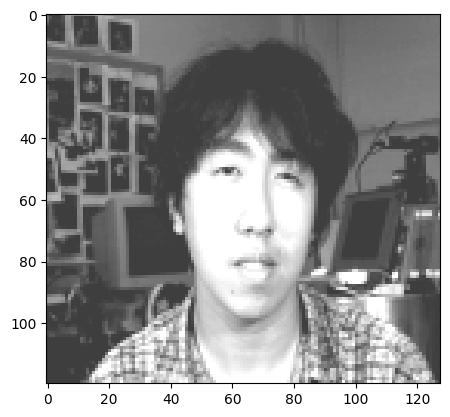

In [39]:
# https://stackoverflow.com/a/70430235 solution to disable some extraneous warnings I got
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

augment_contrast = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(seed=1, factor=0.5),
])
train_aug = randomize(train).map(lambda x, y: (augment_contrast(x), y))
def __test(n):
    i1 = train_aug.skip(n).take(1).get_single_element()[0][0]
    i2 = randomize(train).skip(n).take(1).get_single_element()[0][0]
    def _display(img, _min=0, _max=255):
        plt.imshow(tf.reshape(img, (img_shape[0], img_shape[1], 1)), vmin=_min, vmax=_max, cmap='gray')
        plt.show()
    _display(i1)
    _display(i2)
    _display(i2 - i1, _min=-10, _max=10)
__test(5)

The above demonstrates data augmentation which adjusts contrast. The difference is barely visible between the first and second image. However, when computing the difference (subtraction) between the two images, on a scale of -10 to +10 values, looks like the third image. So, a slight adjustment to the pixel values is occuring to increase contrast.

In [41]:
m6, mu6 = keras_model(final_pooling_layer=False, n_med_filter=3)

# augment after the randomization:
# that way we hopefully get a different augmentation each time we visit a training sample,
# as opposed to only a single augmentation per training sample
hist6 = m6.fit(x=train_aug, validation_data=randomize(val), epochs=160, verbose=0)
print ('done')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 120, 128, 1)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 118, 126, 1)       10        
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 39, 42, 1)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 37, 40, 3)         30        
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 12, 13, 3)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 10, 11, 1)       

62/62 [==============================] - 0s 7ms/step - loss: 0.1758 - binary_accuracy: 0.9355


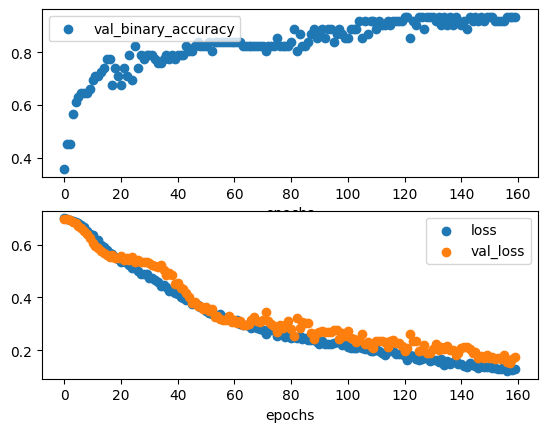

In [42]:
m6.evaluate(val.batch(1))
graphs(hist6)

This is noteably improved performance. We had a ~87% validation accuracy before without data augmentation, and now it is up to >90%. We also see the validation loss increasing, so we are now starting to overfit while using this many iterations, where an equivalent number of iterations without augmentation didn't have this effect.

I will repeat the experiment below, but this time also adding gaussian noise, with a stddev of 100 (roughly 1/3 of 255, the max value of the pixel), before the contrast.

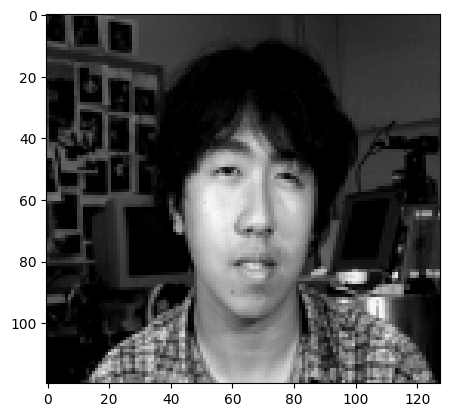

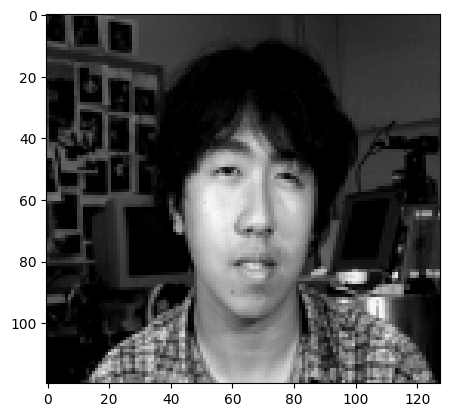

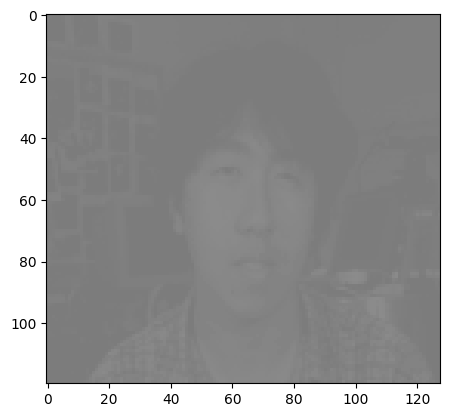

In [43]:
augment2 = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(seed=1, stddev=100),
    tf.keras.layers.RandomContrast(seed=1, factor=0.5),
])
train_aug2 = randomize(train).map(lambda x, y: (augment_contrast(x), y))
def __test2(n):
    i1 = train_aug2.skip(n).take(1).get_single_element()[0][0]
    i2 = randomize(train).skip(n).take(1).get_single_element()[0][0]
    def _display(img, _min=0, _max=255):
        plt.imshow(tf.reshape(img, (img_shape[0], img_shape[1], 1)), vmin=_min, vmax=_max, cmap='gray')
        plt.show()
    _display(i1)
    _display(i2)
    _display(i2 - i1, _min=-10, _max=10)
__test2(5)

In [44]:
m7, mu7 = keras_model(final_pooling_layer=False, n_med_filter=3)
hist7 = m7.fit(x=train_aug2, validation_data=randomize(val), epochs=160, verbose=0)
print ('done')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 120, 128, 1)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 118, 126, 1)       10        
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 39, 42, 1)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 37, 40, 3)         30        
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 12, 13, 3)        0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 10, 11, 1)       

62/62 [==============================] - 0s 6ms/step - loss: 0.3205 - binary_accuracy: 0.9032


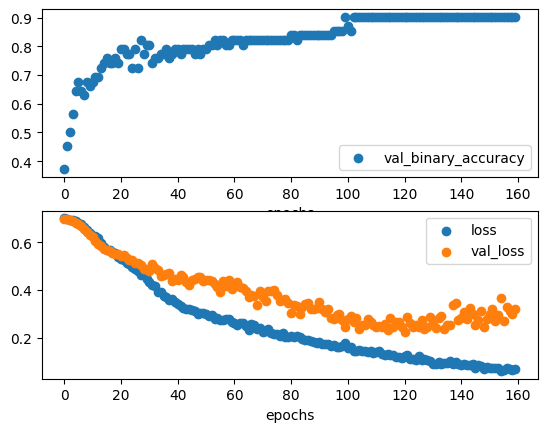

In [45]:
m7.evaluate(val.batch(1))
graphs(hist7)

This yields similar results to the above. I will choose this model to evaluate on the test set.

In [46]:
m7.evaluate(test_set.batch(1))

63/63 [==============================] - 0s 5ms/step - loss: 0.3509 - binary_accuracy: 0.9048


[0.3508678376674652, 0.9047619104385376]

This model achieves ~90% accuracy on the test set! While this is not as good VGG16 which acheived ~95%, it is considerably close for such a simple model.

# Task 2
## Variational Autoencoder
I followed the tutorial mentioned in the homework: https://www.tensorflow.org/tutorials/generative/cvae

I used the faces dataset that I have been working with.

First I had to convert the data to the apropriate format that the model expects. Below is an example of one of the images after it has been rescaled.

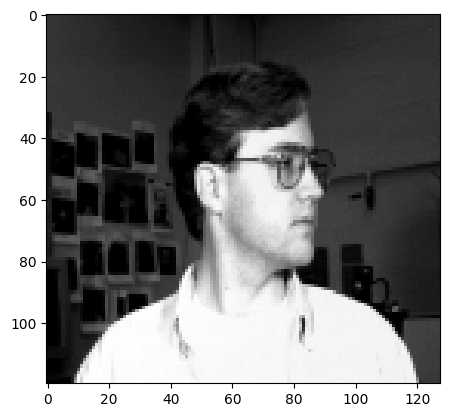

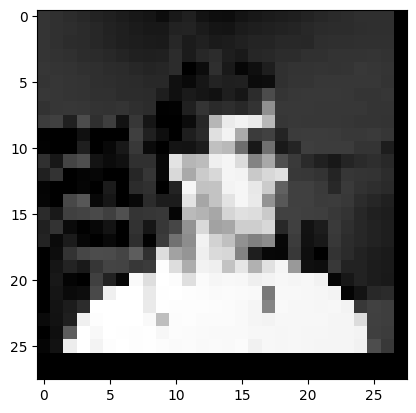

In [49]:
# the models in the tutorials use this shaped image, with 3 channels.
unl_shape = (28, 28)
def convert_unlabeled(ds):
    # convert our image dataset to an unlabeled one, and perform preprocessing (scaling size and pixel values)
    return ds.map(lambda x, y: tf.image.resize_with_pad(x, unl_shape[0], unl_shape[1]) / 255.0)

def imdisplay(img):
    plt.imshow(img, cmap='gray')
    plt.show()

unlabeled_train, unlabeled_val, unlabeled_test = [convert_unlabeled(a) for a in [train, val, test_set]]
imdisplay(train.skip(50).take(1).get_single_element()[0])
imdisplay(unlabeled_train.skip(50).take(1).get_single_element())

Epoch: 75, Test set ELBO: -362.14727783203125


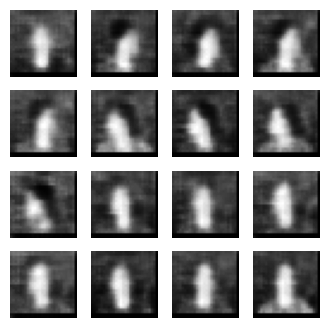

In [50]:
# Note: not original work
# most of this code + architecture is from https://www.tensorflow.org/tutorials/generative/cvae
# which we were instructed to use for the homework
# A few things I changed:
# - increased number of latent dimensions
# - increased number of filters in the "innermost" convolutional layers
latent_dim = 50

# these are the encoder and decoder models,
# the image shape is (28, 28, 1)
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_dim + latent_dim),
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=1, padding='same'),
])

@tf.function
def sample(eps=None):
    if eps is None:
        # noise is uniformly sampled vector in the latent dimension
        eps = tf.random.normal(shape=(100, latent_dim))
    return decode(eps, apply_sigmoid=True)

# apply encoder network
def encode(x):
    mean, logvar = tf.split(encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

# apply decoder network
# apply_sigmoid determines if we output logits or probability values
def decode(z, apply_sigmoid=False):
    logits = decoder(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

# basically the glue that connects the otuput of the encoder to the input of the decoder during training
def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * math.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# loss from encoding and decoding x in the VAE
def compute_loss(x):
    mean, logvar = encode(x)
    z = reparameterize(mean, logvar)
    x_logit = decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def train_step(x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(x)
    var = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, var)
    optimizer.apply_gradients(zip(gradients, var))

def run_cvae():
    adam = tf.keras.optimizers.Adam(1e-4)
    num_examples_to_generate = 16

    random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim], seed=1)

    def generate_and_save_images(epoch, test_sample):
        mean, logvar = encode(test_sample)
        z = reparameterize(mean, logvar)
        predictions = sample(z)
        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')

        plt.savefig('figs/image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

    for test_batch in unlabeled_test.batch(32).take(1):
        test_sample = test_batch[0:num_examples_to_generate, :, :, :]

    generate_and_save_images(0, test_sample)

    epochs = 75
    for epoch in range(1, epochs + 1):
        for train_x in randomize(unlabeled_train):
            train_step(train_x, adam)

        loss = tf.keras.metrics.Mean()
        for test_x in randomize(convert_unlabeled(val)):
            loss(compute_loss(test_x))
        elbo = -loss.result()
        IPython.display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}'.format(epoch, elbo))
        generate_and_save_images(epoch, test_sample)

run_cvae()

I tweaked a few hyperparameters such as number of filters and number of latent dimensions, but could not get the ELBO loss function greater than ~-360, so I think that this is the best the model can achieve.

It is able to reproduce photos that give a vague silhouette of a person in a dark room looking in various directions. We also see some darker regions near the head for images where the person is looking to the side, which appears to be the hair.

## Generative Adversarial Networks
I followed the tutorial mentioned in the homework: https://www.tensorflow.org/tutorials/generative/dcgan

I used the faces dataset that I have been working with.

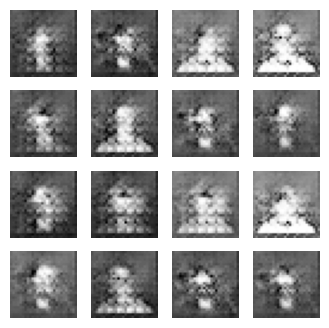

In [51]:
# Note: not original work
# most of this code + architecture is from https://www.tensorflow.org/tutorials/generative/dcgan
# which we were instructed to use for the homework

# outputs image of shape (28, 28, 1)
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'),
])

# outputs classification decision in terms of a log-odds value
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([32, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate single batch of images using random noise as input to the generator
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

checkpoint_prefix = './checkpoints/'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)
    
def train(dataset, epochs):
    seed = tf.random.normal([16, noise_dim], seed=1)
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        IPython.display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        print ('epoch {} done'.format(epoch + 1))
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
    IPython.display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig('figs2/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

train(randomize(unlabeled_train), 150)

Compared to the VAE, the convolutional GAN requires a lot more epochs to get decent results, and also has a significant amount of noise / distortions in the result.

Likely, the ability of the GAN to produce more distinctive features in the output is the same reason why some parts have a lot of these distortions, because the network has the ability to generate regions of pixels with significantly different contrast, whereas with the VAE convolution network, these small distinctive features couldn't be generated since it didn't have as large of a fully connected layer.

As we can see in the results, we get vague human like shapes in the output, however with a good amount of distortion around the ehad. We see more distortion in the center of the face, where distinctive features like sunglasses tend to be, which is something we definitely didn't see with the VAE convolution model.